In [1]:
import pandas as pd; pd.set_option('precision',4)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np; np.set_printoptions(precision=4,suppress = True)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.gridspec as gridspec


fontsize = 15 # Set fontsize for all figures
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title


# StandardScale all x-variables - improves performance and robustness of fitted models
from sklearn.preprocessing import StandardScaler

# All subsets need their own scaler in order to call the inverse_transform method
scaler_train = StandardScaler()
scaler_test = StandardScaler()
scaler_all = StandardScaler()


def printf(text, value, pct=False):
    if pct == True:
        print(text, f"{value*100:.4f}%")
    else:
        print(text, f"{value:.4f}")

In [3]:
import os 
cwd = os.getcwd()
print(os.getcwd())
os.chdir('/home/math/PycharmProjects/hmm-master')

/home/math/PycharmProjects/hmm-master/notebooks


In [4]:
df = pd.read_csv('data/price_series.csv', index_col = 'Time')

df.index = pd.to_datetime(df.index)

df_yield = pd.read_excel('data/BarCap_USCorpHY_10yearspread.xlsx', header = 2, index_col = 'date')
df_yield.index = pd.to_datetime(df_yield.index)
df_yield.rename(columns={'Unnamed: 1':'Yield Spread'}, inplace=True)

In [5]:
df_MSCI = df[['MSCI World']]
df_DAX = df[['DAX ']]
df_SP500 = df[['S&P 500 ']]

df_MSCI.dropna(inplace=True)
df_DAX.dropna(inplace=True)
df_SP500.dropna(inplace=True)

df_MSCI['MSCI Index'] = df_MSCI / df_MSCI['MSCI World'][0] * 100

df_DAX['DAX Index'] = df_DAX / df_DAX['DAX '][0]*100

df_SP500['S&P 500 Index'] = df_SP500 / df_SP500['S&P 500 '][0]*100

#### Returns MSCI 

In [6]:
df_MSCI['Returns'] = df_MSCI['MSCI Index'].pct_change()
df_MSCI['Log returns'] = np.log(df_MSCI['MSCI Index']) - np.log(df_MSCI['MSCI Index'].shift(1))
df_MSCI

,MSCI World,MSCI Index,Returns,Log returns
Time,,,,
1969-12-31,100.00,100.00,NaN,NaN
1970-01-07,100.67,100.67,0.0067,0.0067
1970-01-14,99.77,99.77,-0.0089,-0.0090
1970-01-21,98.38,98.38,-0.0139,-0.0140
1970-01-28,95.91,95.91,-0.0251,-0.0254
...,...,...,...,...
2021-02-08,2795.89,2795.89,0.0081,0.0081
2021-02-09,2798.55,2798.55,0.0010,0.0010
2021-02-10,2800.68,2800.68,0.0008,0.0008


#### Returns DAX

In [7]:
df_DAX['Returns'] = df_DAX['DAX Index'].pct_change()
df_DAX['Log returns'] = np.log(df_DAX['DAX Index']) - np.log(df_DAX['DAX Index'].shift(1))
df_DAX

,DAX,DAX Index,Returns,Log returns
Time,,,,
1999-01-04,6208.8148,100.0000,NaN,NaN
1999-01-05,6181.7505,99.5641,-0.0044,-0.0044
1999-01-06,6323.8534,101.8528,0.0230,0.0227
1999-01-07,6218.5739,100.1572,-0.0166,-0.0168
1999-01-08,6240.5944,100.5118,0.0035,0.0035
...,...,...,...,...
2021-02-08,16937.9736,272.8053,0.0010,0.0010
2021-02-09,16961.2839,273.1807,0.0014,0.0014
2021-02-10,16911.8390,272.3843,-0.0029,-0.0029


#### Returns SP500 

In [8]:
df_SP500['Returns'] = df_SP500['S&P 500 Index'].pct_change()
df_SP500['Log returns'] = np.log(df_SP500['S&P 500 Index']) - np.log(df_SP500['S&P 500 Index'].shift(1))
df_SP500

,S&P 500,S&P 500 Index,Returns,Log returns
Time,,,,
1960-01-04,59.91,100.0000,NaN,NaN
1960-01-05,60.39,100.8012,0.0080,0.0080
1960-01-06,60.13,100.3672,-0.0043,-0.0043
1960-01-07,59.69,99.6328,-0.0073,-0.0073
1960-01-08,59.50,99.3156,-0.0032,-0.0032
...,...,...,...,...
2021-02-08,3915.59,6535.7870,0.0074,0.0074
2021-02-09,3911.23,6528.5094,-0.0011,-0.0011
2021-02-10,3909.88,6526.2561,-0.0003,-0.0003


### Yield Calculations

In [9]:
df_yield['Yield Index'] = df_yield['Yield Spread'] / df_yield['Yield Spread'][0] * 100
df_yield['Returns'] = df_yield['Yield Index'].pct_change() 
df_yield['Log returns'] = np.log(df_yield['Yield Index']) - np.log(df_yield['Yield Index'].shift(1))
df_yield['Inverse yield'] = df_yield['Yield Spread'] * -1

### Data Exploration MSCI World

In [10]:
from datetime import datetime

# Set train and test periods
start_train = '1969-12-31'
end_train = '2015-01-01'

start_test = '2015-01-02'
end_test = '2021-02-12'

# Get train and test as datetimes - used for plotting
start_train_dt = datetime.strptime(start_train, '%Y-%m-%d')
end_train_dt = datetime.strptime(end_train, '%Y-%m-%d')
start_test_dt = datetime.strptime(start_test, '%Y-%m-%d')
end_test_dt = datetime.strptime(end_test, '%Y-%m-%d')

df_MSCI = df_MSCI.loc[start_train:end_test]

#### Overview of time series

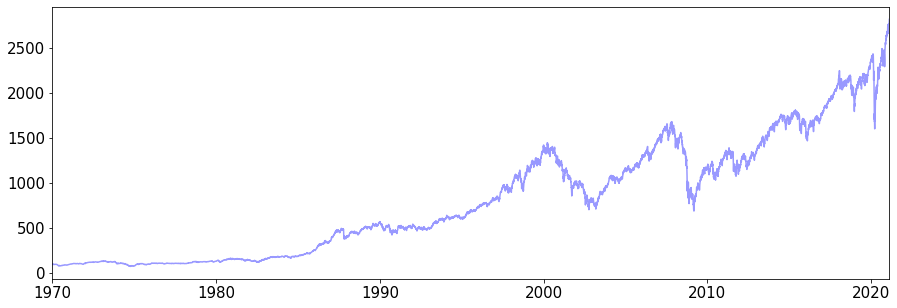

<Figure size 432x288 with 0 Axes>

In [12]:
ig, ax = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax.plot(df_MSCI.index.values,df_MSCI['MSCI Index'], color="b", alpha=0.4)
ax.set_xlim(start_train_dt, end_test_dt)
plt.show()
save_results_to = '/home/math/PycharmProjects/hmm-master/analysis/data_description/'
plt.savefig(save_results_to + 'MSCI_index.png', dpi=300)

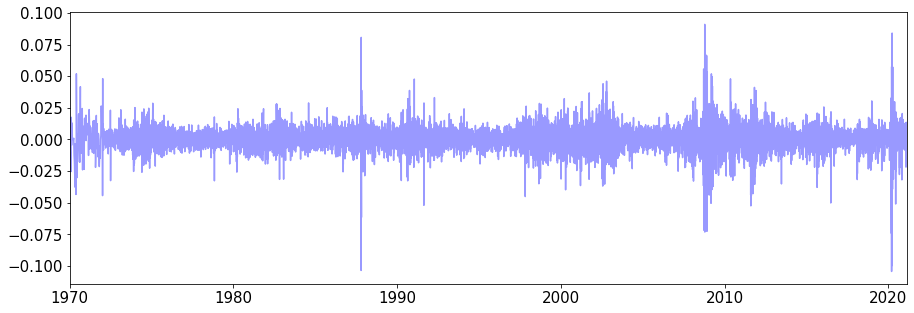

<Figure size 432x288 with 0 Axes>

In [13]:
fig, ax1 = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax1.plot(df_MSCI.index.values,df_MSCI['Log returns'], color="b", alpha=0.4)
ax1.set_xlim(start_train_dt, end_test_dt)
plt.show()
plt.savefig(save_results_to + 'MSCI_log_returns.png', dpi = 300)

In [14]:
# Summary statistics for MSCI Data.

#Drop the first observation that is nan in order to obtain jarque bera test stat. 
print('Mean MSCI =', df_MSCI['Log returns'].mean())
print('STD MSCI = ', df_MSCI['Log returns'].std())
print('25% Quantile MSCI =', df_MSCI['Log returns'].quantile(q=0.25))
print('75% Quantile MSCI', df_MSCI['Log returns'].quantile(q=0.75))
print('Min daily return MSCI', df_MSCI['Log returns'].min())
print('Max daily return MSCI', df_MSCI['Log returns'].max())
print('Skewness MSCI = ', df_MSCI['Log returns'].skew())
print('Kurtosis MSCI = ', df_MSCI['Log returns'].kurtosis())
print('Annual Mean MSCI', (1+df_MSCI['Log returns'].mean())**252-1)
print('Annual STD =', df_MSCI['Log returns'].std() * np.sqrt(252))
print('Annual Sharpe =', ((1+df_MSCI['Log returns'].mean())**252-1)/(df_MSCI['Log returns'].std() * np.sqrt(252)))
print('JB-test MSCI =', stats.jarque_bera(df_MSCI['Log returns']))

Mean MSCI = 0.00025803045543678645
STD MSCI =  0.008717234647186005
25% Quantile MSCI = -0.0037010212317714064
75% Quantile MSCI 0.004532196755339779
Min daily return MSCI -0.10441721632126022
Max daily return MSCI 0.09096365880468049
Skewness MSCI =  -0.6520842872916004
Kurtosis MSCI =  13.881947735038839
Annual Mean MSCI 0.06717533834887135
Annual STD = 0.1383818099799003
Annual Sharpe = 0.48543474289452093
JB-test MSCI = Jarque_beraResult(statistic=nan, pvalue=nan)


#### Fitting of distribution

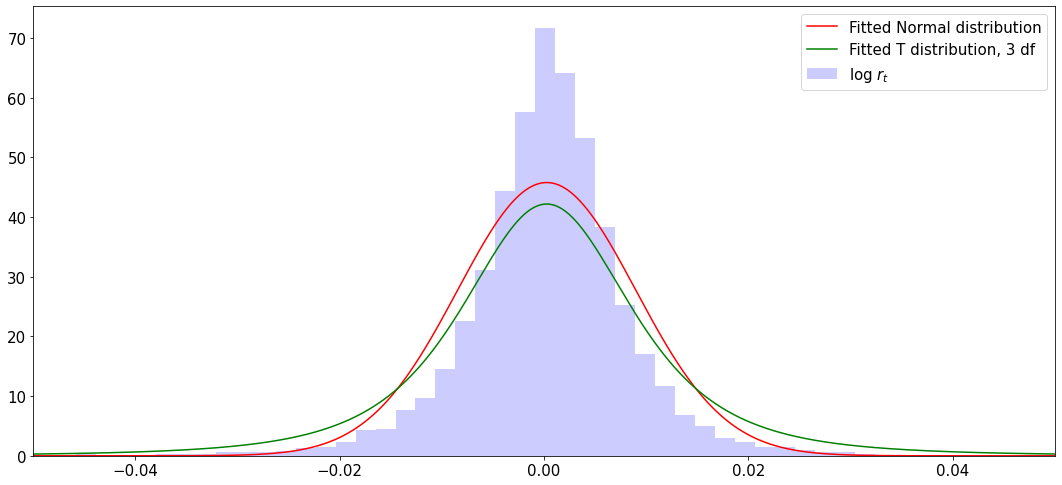

In [15]:
x = np.linspace(-0.05, 0.05, 10000)
fig, ax = plt.subplots(figsize=(15,7))

plt.hist(df_MSCI["Log returns"], bins=100, density=True, color="b", alpha=0.2, label="log $r_t$")
plt.plot(x, stats.norm.pdf(x, loc=df_MSCI["Log returns"].mean(), scale =df_MSCI["Log returns"].std()),
             label="Fitted Normal distribution", color="red")
plt.plot(x, stats.t.pdf(x, df=3, loc=df_MSCI['Log returns'].mean(), scale = df_MSCI['Log returns'].std())
        , label = 'Fitted T distribution, 3 df', color = 'green')
plt.xlim(-0.05, 0.05)
plt.tight_layout()
plt.legend()
plt.savefig(save_results_to + 'MSCI_distribution.png', dpi = 300)

In [16]:
outliers_left = len(df_MSCI[df_MSCI['Log returns'] < -3*df_MSCI['Log returns'].std()+df_MSCI['Log returns'].mean()])
outliers_left

outliers_right = len(df_MSCI[df_MSCI['Log returns']>3*df_MSCI['Log returns'].std()+df_MSCI['Log returns'].mean()])
outliers_right

total_outliers = outliers_left + outliers_right
total_outliers

187

#### Drawdown Calculation

In [18]:
#Previous_peaks = df_MSCI['MSCI Index'].cummax()
#df_MSCI['drawdown'] = (df_MSCI['MSCI Index']-Previous_peaks)/Previous_peaks
#df_MSCI.head()

In [19]:
#fig, ax3 = plt.subplots(figsize=(15,7))
#plt.subplots_adjust(wspace = 0.2, hspace=0.1)
#ax3.plot(df_MSCI.index.values,df_MSCI['drawdown'], color="b", alpha=0.4)
#ax3.set_ylim(-0.8,0.05)
#ax3.set_xlim(start_train_dt, end_test_dt)
#plt.show()

### ACF and absolute ACF - MSCI

In [20]:
#### Compute ACF
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(df_MSCI['Log returns'].dropna(),nlags = n_lags)[1:] #The 1: excludes the first observation which obviouslyh is 1.

#### Compute ACF2
acf_abs = sm.tsa.acf(np.abs(df_MSCI['Log returns'].dropna()), nlags=n_lags)[1:]

/home/math/PycharmProjects/hmm-master/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [21]:
#### Confidence interval for ACF
acf_conf = [1.96  / np.sqrt(len(df_MSCI)), -1.96 / np.sqrt(len(df_MSCI))]

#### Confidence interval for ACF^2
acf_abs_conf = [1.96 / np.sqrt(len(np.abs(df_MSCI['Log returns']))), - 1.96 / np.sqrt(len(np.abs(df_MSCI['Log returns'])))]

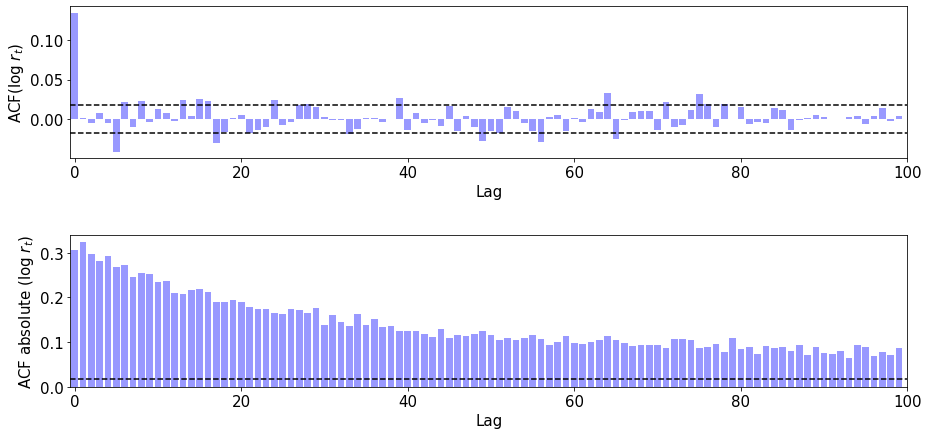

In [22]:
# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF(log $r_t)$","ACF absolute (log $r_t$)"]
variables = [acf, acf_abs]
confidence = [acf_conf, acf_abs_conf]

for (ax, labels, var, conf) in zip([ax1, ax2], labels, variables, confidence):
    ax.bar(lags, var, color="b", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(labels)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig(save_results_to + 'MSCI_ACF.png', dpi = 300)


### Data Exploration DAX

In [23]:
# Set train and test periods
start_train_dax = '1999-01-04'
end_train_dax = '2015-01-01'

start_test_dax = '2015-01-02'
end_test_dax = '2021-02-12'

# Get train and test as datetimes - used for plotting
start_train_dt_dax = datetime.strptime(start_train_dax, '%Y-%m-%d')
end_train_dt_dax = datetime.strptime(end_train_dax, '%Y-%m-%d')
start_test_dt_dax = datetime.strptime(start_test_dax, '%Y-%m-%d')
end_test_dt_dax = datetime.strptime(end_test_dax, '%Y-%m-%d')

df_DAX = df_DAX.loc[start_train:end_test]

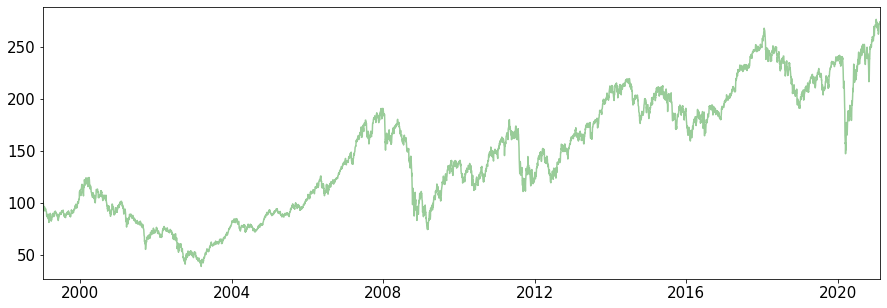

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax.plot(df_DAX.index.values,df_DAX['DAX Index'], color="g", alpha=0.4)
ax.set_xlim(start_train_dt_dax, end_test_dt_dax)
plt.show()
plt.savefig(save_results_to + 'DAX_index.png', dpi = 300)

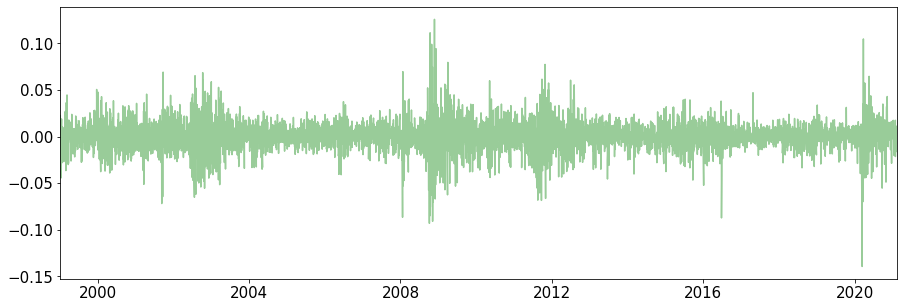

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax.plot(df_DAX.index.values,df_DAX['Log returns'], color="g", alpha=0.4)
ax.set_xlim(start_train_dt_dax, end_test_dt_dax)
plt.savefig(save_results_to + 'DAX_log_returns.png', dpi = 300)
plt.show()

#### Calculation of summary statistics

In [26]:
# Summary statistics for DAX Data.

#Drop the first observation that is nan in order to obtain jarque bera test stat. 
print('Mean DAX =', df_DAX['Log returns'].mean())
print('STD DAX = ', df_DAX['Log returns'].std())
print('25% Quantile DAX =', df_DAX['Log returns'].quantile(q=0.25))
print('75% Quantile DAX', df_DAX['Log returns'].quantile(q=0.75))
print('Min daily return DAX', df_DAX['Log returns'].min())
print('Max daily return DAX', df_DAX['Log returns'].max())
print('Skewness DAX = ', df_DAX['Log returns'].skew())
print('Kurtosis DAX = ', df_DAX['Log returns'].kurtosis())
print('Annual STD =', df_DAX['Log returns'].std() * np.sqrt(252))
print('Annual Sharpe =', ((1+df_DAX['Log returns'].mean())**252-1)/(df_DAX['Log returns'].std() * np.sqrt(252)))
print('JB-test DAX =', stats.jarque_bera(df_DAX['Log returns']))

Mean DAX = 0.00017982251081400703
STD DAX =  0.015874249829185814
25% Quantile DAX = -0.007143962503065371
75% Quantile DAX 0.008154791205657874
Min daily return DAX -0.13936001783108232
Max daily return DAX 0.12572385310766165
Skewness DAX =  -0.18689603728092744
Kurtosis DAX =  5.811502720127117
Annual STD = 0.25199590378641135
Annual Sharpe = 0.18394518540433216
JB-test DAX = Jarque_beraResult(statistic=nan, pvalue=nan)


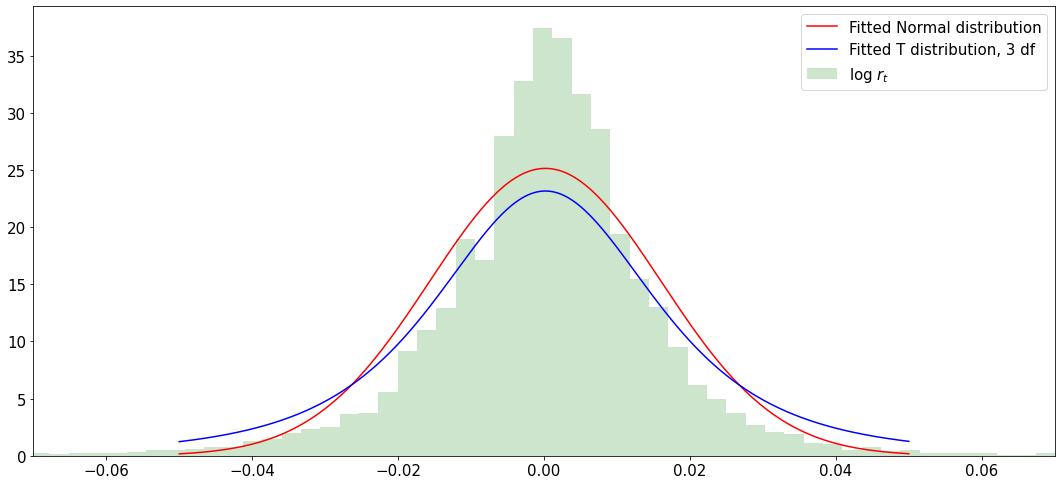

In [27]:
x = np.linspace(-0.05, 0.05, 10000)
fig, ax = plt.subplots(figsize=(15,7))

plt.hist(df_DAX["Log returns"], bins=100, density=True, color="g", alpha=0.2, label="log $r_t$")
plt.plot(x, stats.norm.pdf(x, loc=df_DAX["Log returns"].mean(), scale =df_DAX["Log returns"].std()),
             label="Fitted Normal distribution", color="red")
plt.plot(x, stats.t.pdf(x, df=3, loc=df_DAX['Log returns'].mean(), scale = df_DAX['Log returns'].std())
        , label = 'Fitted T distribution, 3 df', color = 'blue')
plt.xlim(-0.07, 0.07)
plt.tight_layout()
plt.legend()
plt.savefig(save_results_to + 'DAX_distribution.png', dpi = 300)

#### ACF and Abs ACF

In [29]:
### Compute ACF for train set:
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(df_DAX['Log returns'].dropna(),nlags = n_lags)[1:] #The 1: excludes the first observation which obviouslyh is 1.

#### Compute ACF2
acf_abs = sm.tsa.acf(np.abs(df_DAX['Log returns'].dropna()), nlags=n_lags)[1:]

/home/math/PycharmProjects/hmm-master/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


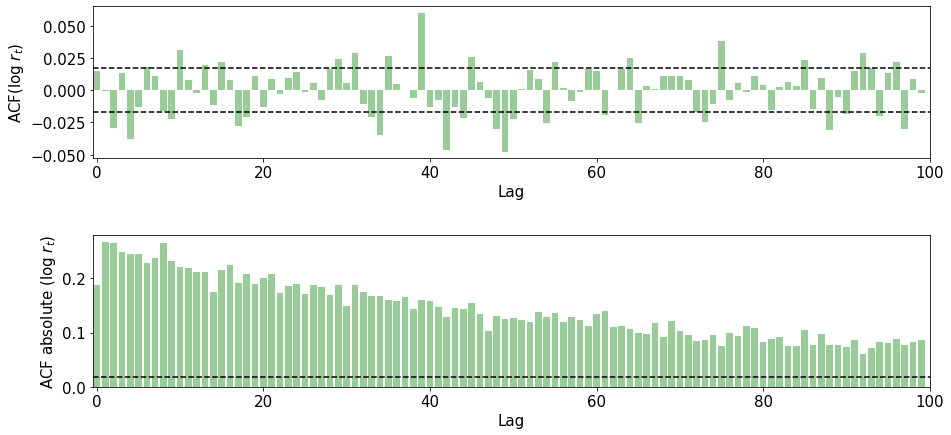

In [30]:
# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF(log $r_t)$","ACF absolute (log $r_t$)"]
variables = [acf, acf_abs]
confidence = [acf_conf, acf_abs_conf]

for (ax, labels, var, conf) in zip([ax1, ax2], labels, variables, confidence):
    ax.bar(lags, var, color="g", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(labels)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig(save_results_to + 'DAX_ACF.png', dpi = 300)

### Data Exploration S&P 500

In [31]:
# Set train and test periods
start_train_sp500 = '1960-01-04'
end_train_sp500 = '2015-01-01'

start_test_sp500 = '2015-01-02'
end_test_sp500 = '2021-02-12'

# Get train and test as datetimes - used for plotting
start_train_dt_sp500 = datetime.strptime(start_train_sp500, '%Y-%m-%d')
end_train_dt_sp500 = datetime.strptime(end_train_sp500, '%Y-%m-%d')
start_test_dt_sp500 = datetime.strptime(start_test_sp500, '%Y-%m-%d')
end_test_dt_sp500 = datetime.strptime(end_test_sp500, '%Y-%m-%d')

df_SP500 = df_SP500.loc[start_train_sp500:end_test_sp500]

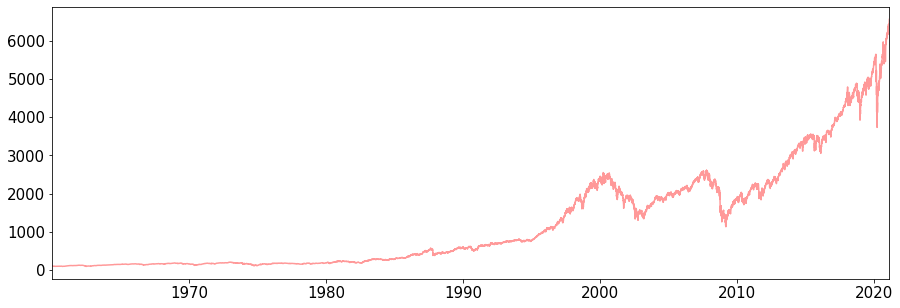

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax.plot(df_SP500.index.values,df_SP500['S&P 500 Index'], color="r", alpha=0.4)
ax.set_xlim(start_train_dt_sp500, end_test_dt_sp500)
plt.savefig(save_results_to + 'SP500_index.png', dpi = 300)
plt.show()

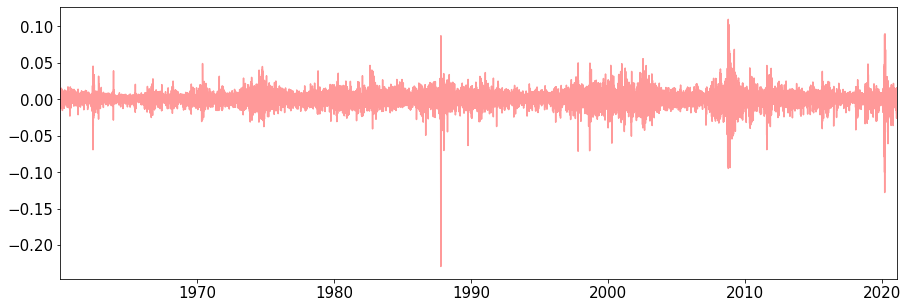

<Figure size 432x288 with 0 Axes>

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax.plot(df_SP500.index.values,df_SP500['Log returns'], color="r", alpha=0.4)
ax.set_xlim(start_train_dt_sp500, end_test_dt_sp500)
plt.show()
plt.savefig(save_results_to + 'SP500_log_returns.png', dpi = 300)

In [34]:
# Summary statistics for SP500 Data.

#Drop the first observation that is nan in order to obtain jarque bera test stat. 
print('Mean S&P500 =', df_SP500['Log returns'].mean())
print('STD S&P500 = ', df_SP500['Log returns'].std())
print('25% Quantile S&P500 =', df_SP500['Log returns'].quantile(q=0.25))
print('75% Quantile S&P500', df_SP500['Log returns'].quantile(q=0.75))
print('Min daily return S&P500', df_SP500['Log returns'].min())
print('Max daily return S&P500', df_SP500['Log returns'].max())
print('Skewness S&P500 = ', df_SP500['Log returns'].skew())
print('Kurtosis S&P500 = ', df_SP500['Log returns'].kurtosis())
print('Annual STD =', df_SP500['Log returns'].std() * np.sqrt(252))
print('Annual Sharpe =', ((1+df_SP500['Log returns'].mean())**252-1)/(df_SP500['Log returns'].std() * np.sqrt(252)))
print('JB-test S&P500 =', stats.jarque_bera(df_SP500['Log returns']))

Mean S&P500 = 0.000272021549778302
STD S&P500 =  0.010274247245473725
25% Quantile S&P500 = -0.004206687797434272
75% Quantile S&P500 0.005072198812962725
Min daily return S&P500 -0.2289972265656699
Max daily return S&P500 0.10957195934756747
Skewness S&P500 =  -1.035286114469068
Kurtosis S&P500 =  26.833760697795135
Annual STD = 0.1630986187194832
Annual Sharpe = 0.4349735079294929
JB-test S&P500 = Jarque_beraResult(statistic=nan, pvalue=nan)


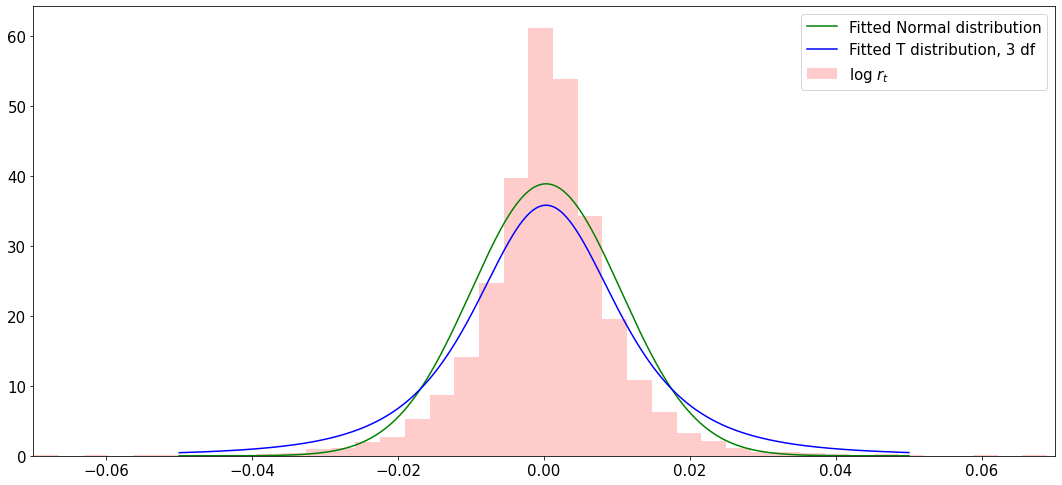

In [35]:
x = np.linspace(-0.05, 0.05, 10000)
fig, ax = plt.subplots(figsize=(15,7))

plt.hist(df_SP500["Log returns"], bins=100, density=True, color="r", alpha=0.2, label="log $r_t$")
plt.plot(x, stats.norm.pdf(x, loc=df_SP500["Log returns"].mean(), scale =df_SP500["Log returns"].std()),
             label="Fitted Normal distribution", color="green")
plt.plot(x, stats.t.pdf(x, df=3, loc=df_SP500['Log returns'].mean(), scale = df_SP500['Log returns'].std())
        , label = 'Fitted T distribution, 3 df', color = 'blue')
plt.xlim(-0.07, 0.07)
plt.tight_layout()
plt.legend()
plt.savefig(save_results_to + 'SP500_distribution.png', dpi = 300)

In [36]:
### Compute ACF for train set:
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(df_SP500['Log returns'].dropna(),nlags = n_lags)[1:] #The 1: excludes the first observation which obviouslyh is 1.

#### Compute ACF2
acf_abs = sm.tsa.acf(np.abs(df_SP500['Log returns'].dropna()), nlags=n_lags)[1:]

/home/math/PycharmProjects/hmm-master/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


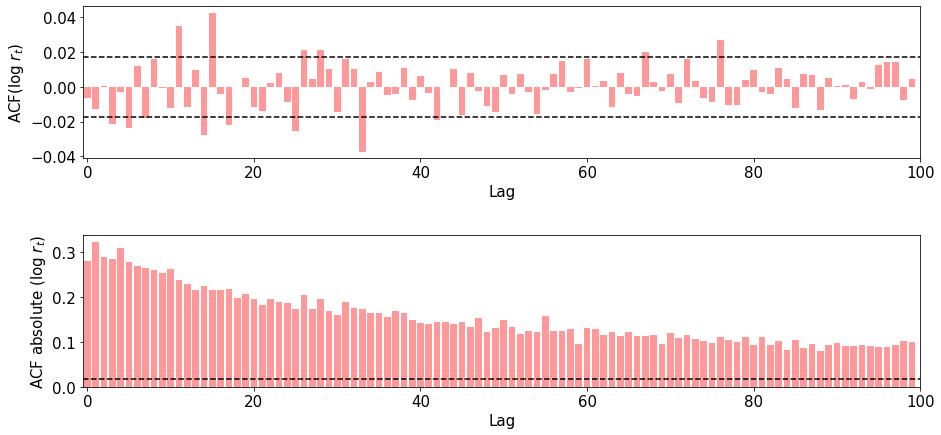

In [37]:
# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF(log $r_t)$","ACF absolute (log $r_t$)"]
variables = [acf, acf_abs]
confidence = [acf_conf, acf_abs_conf]

for (ax, labels, var, conf) in zip([ax1, ax2], labels, variables, confidence):
    ax.bar(lags, var, color="r", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(labels)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig(save_results_to + 'SP500_ACF', dpi = 300)

### Data Exploration: HY

In [38]:
df_yield

,Yield Spread,Yield Index,Returns,Log returns,Inverse yield
date,,,,,
1987-01-30,5.03,100.0000,NaN,NaN,-5.03
1987-02-02,5.01,99.6024,-0.0040,-0.0040,-5.01
1987-02-03,4.99,99.2048,-0.0040,-0.0040,-4.99
1987-02-04,4.99,99.2048,0.0000,0.0000,-4.99
1987-02-05,5.08,100.9940,0.0180,0.0179,-5.08
...,...,...,...,...,...
2021-02-08,2.80,55.6660,-0.0244,-0.0247,-2.80
2021-02-09,2.80,55.6660,0.0000,0.0000,-2.80
2021-02-10,2.83,56.2624,0.0107,0.0107,-2.83


In [39]:
# Set train and test periods
start_train_yield = '1987-01-30'
end_train_yield = '2015-01-01'

start_test_yield = '2015-01-02'
end_test_yield = '2021-02-12'

# Get train and test as datetimes - used for plotting
start_train_dt_yield = datetime.strptime(start_train_yield, '%Y-%m-%d')
end_train_dt_yield = datetime.strptime(end_train_yield, '%Y-%m-%d')
start_test_dt_yield = datetime.strptime(start_test_yield, '%Y-%m-%d')
end_test_dt_yield = datetime.strptime(end_test_yield, '%Y-%m-%d')

df_yield = df_yield.loc[start_train:end_test]

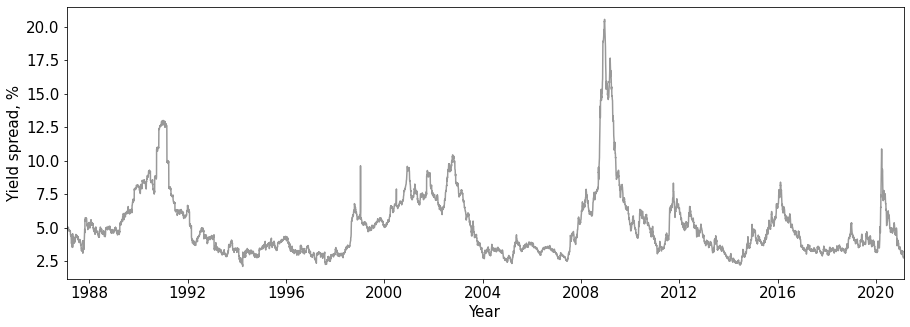

<Figure size 432x288 with 0 Axes>

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax.plot(df_yield.index.values,df_yield['Yield Spread'], color="black", alpha=0.4)
ax.set_xlim(start_train_dt_yield, end_test_dt_yield)
plt.ylabel('Yield spread, %')
plt.xlabel('Year')
plt.show()
plt.savefig(save_results_to + 'yield_index.png', dpi = 300)

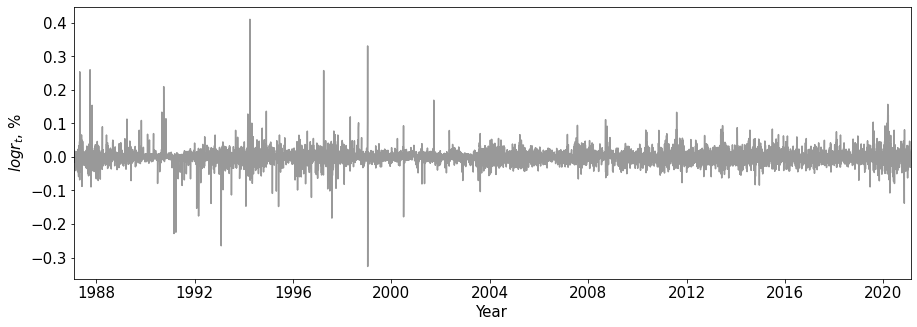

<Figure size 432x288 with 0 Axes>

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax.plot(df_yield.index.values,df_yield['Log returns'], color="black", alpha=0.4)
ax.set_xlim(start_train_dt_yield, end_test_dt_yield)
plt.ylabel('$log r_t$, %')
plt.xlabel('Year')
plt.show()
plt.savefig(save_results_to + 'yield_log_returns.png', dpi = 300)

In [42]:
print('Mean yield =', df_yield['Log returns'].mean())
print('STD yield = ', df_yield['Log returns'].std())
print('25% Quantile yield =', df_yield['Log returns'].quantile(q=0.25))
print('75% Quantile yield', df_yield['Log returns'].quantile(q=0.75))
print('Min daily return yield', df_yield['Log returns'].min())
print('Max daily return yield', df_yield['Log returns'].max())
print('Skewness yield = ', df_yield['Log returns'].skew())
print('Kurtosis yield = ', df_yield['Log returns'].kurtosis())
print('Annual STD =', df_yield['Log returns'].std() * np.sqrt(252))
print('JB-test yield =', stats.jarque_bera(df_yield['Log returns']))

Mean yield = -6.800530154670216e-05
STD yield =  0.022283601847602395
25% Quantile yield = -0.009497500658195435
75% Quantile yield 0.008698239924711082
Min daily return yield -0.3265424901589018
Max daily return yield 0.41019324930410983
Skewness yield =  0.8915604750124627
Kurtosis yield =  41.12092691624794
Annual STD = 0.35374121282121224
JB-test yield = Jarque_beraResult(statistic=nan, pvalue=nan)


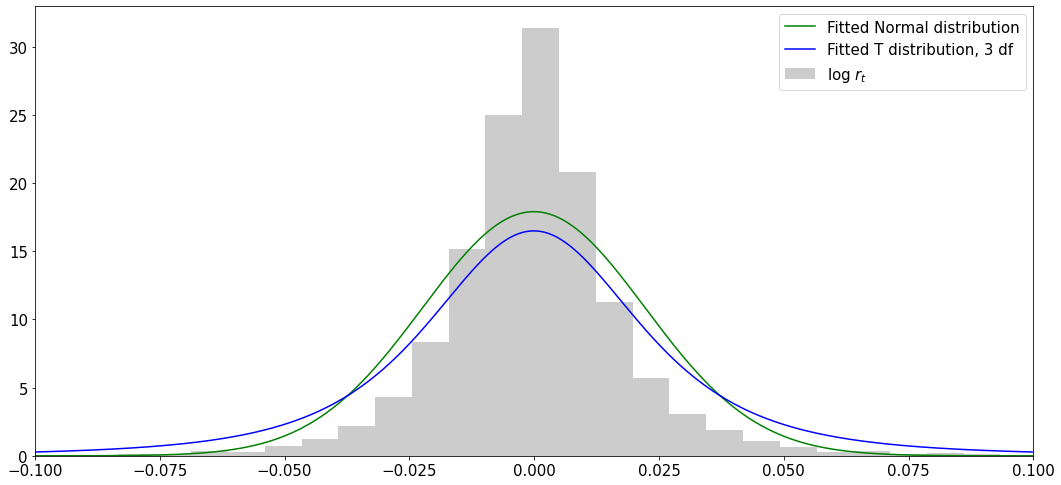

In [43]:
x = np.linspace(-0.10, 0.1, 10000)
fig, ax = plt.subplots(figsize=(15,7))

plt.hist(df_yield["Log returns"], bins=100, density=True, color="black", alpha=0.2, label="log $r_t$")
plt.plot(x, stats.norm.pdf(x, loc=df_yield["Log returns"].mean(), scale =df_yield["Log returns"].std()),
             label="Fitted Normal distribution", color="green")
plt.plot(x, stats.t.pdf(x, df=3, loc=df_yield['Log returns'].mean(), scale = df_yield['Log returns'].std())
        , label = 'Fitted T distribution, 3 df', color = 'blue')
plt.xlim(-0.10, 0.10)
plt.tight_layout()
plt.legend()
plt.savefig(save_results_to + 'yield_distribution.png', dpi = 300)

In [44]:
### Compute ACF for train set:
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(df_yield['Log returns'].dropna(),nlags = n_lags)[1:] #The 1: excludes the first observation which obviouslyh is 1.

#### Compute ACF2
acf_abs = sm.tsa.acf(np.abs(df_yield['Log returns'].dropna()), nlags=n_lags)[1:]

/home/math/PycharmProjects/hmm-master/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


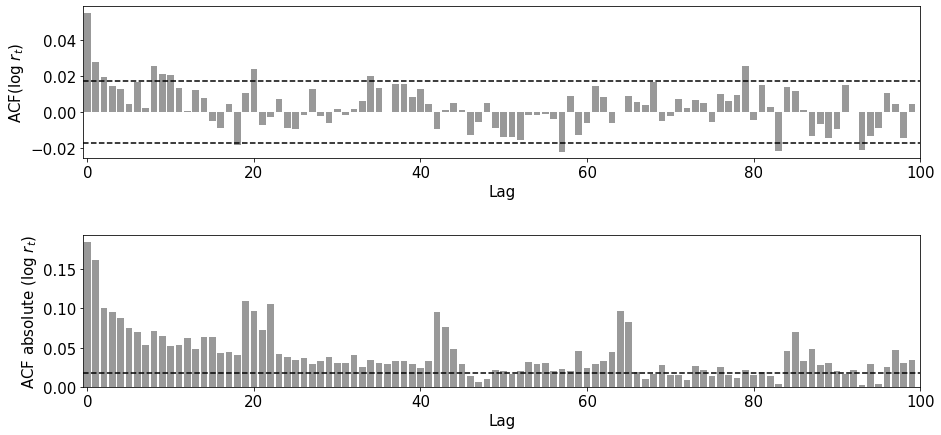

In [45]:
# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF(log $r_t)$","ACF absolute (log $r_t$)"]
variables = [acf, acf_abs]
confidence = [acf_conf, acf_abs_conf]

for (ax, labels, var, conf) in zip([ax1, ax2], labels, variables, confidence):
    ax.bar(lags, var, color="black", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(labels)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig(save_results_to + 'yield_ACF.png', dpi = 300)

### Overview of combined indexes

In [46]:
df_comb = df[['MSCI World', 'DAX ', 'S&P 500 ']]

In [47]:
df_comb.dropna(inplace=True)

In [48]:
df_comb.head(5)

,MSCI World,DAX,S&P 500
Time,,,
1999-01-04,1161.52,6208.8148,1228.10
1999-01-05,1173.34,6181.7505,1244.78
1999-01-06,1195.45,6323.8534,1272.34
1999-01-07,1191.63,6218.5739,1269.73
1999-01-08,1190.77,6240.5944,1275.09


In [49]:
df_comb['MSCI Index'] = df_comb['MSCI World'] / df_comb['MSCI World'][0] * 100
df_comb['DAX Index'] = df_comb['DAX '] / df_comb['DAX '][0]*100
df_comb['S&P 500 Index'] = df_comb['S&P 500 '] / df_comb['S&P 500 '][0]*100


In [51]:
#Set train and test periods
start_train_comb = '1999-01-04'
end_train_comb = '2015-01-01'

start_test_comb = '2015-01-02'
end_test_comb = '2021-02-12'

# Get train and test as datetimes - used for plotting
start_train_dt_comb = datetime.strptime(start_train_comb, '%Y-%m-%d')
end_train_dt_comb = datetime.strptime(end_train_comb, '%Y-%m-%d')
start_test_dt_comb = datetime.strptime(start_test_comb, '%Y-%m-%d')
end_test_dt_comb = datetime.strptime(end_test_comb, '%Y-%m-%d')

df_comb = df_comb.loc[start_train_comb:end_test_comb]

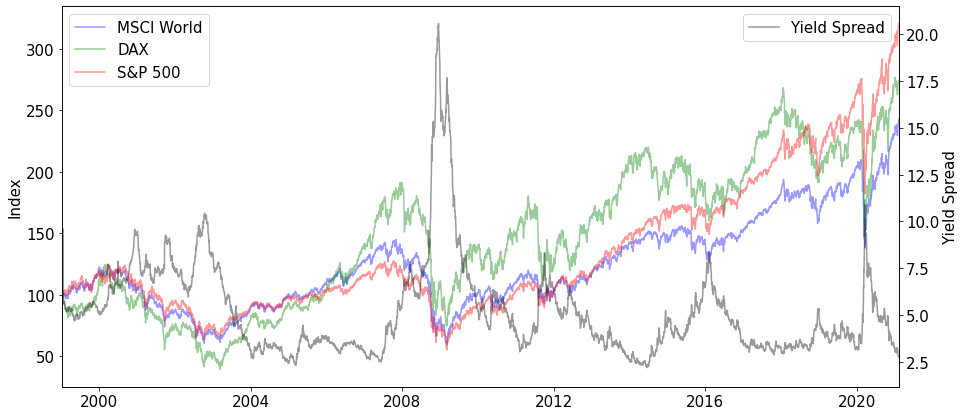

<Figure size 432x288 with 0 Axes>

In [52]:
fig, ax = plt.subplots(figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)

ax2 = ax.twinx()

ax.plot(df_comb.index.values,df_comb['MSCI Index'], color="b", alpha=0.4, label='MSCI World')
ax.plot(df_comb.index.values,df_comb['DAX Index'], color="g", alpha=0.4, label = 'DAX')
ax.plot(df_comb.index.values,df_comb['S&P 500 Index'], color="r", alpha=0.4, label= 'S&P 500')
ax2.plot(df_yield.index.values, df_yield['Yield Spread'], color='black', alpha=0.4, label='Yield Spread')
ax2.set_ylabel("Yield Spread")
ax2
ax.set_xlim(start_train_dt_comb, end_test_dt_comb)
plt.xlabel('Year')
ax.set_ylabel('Index')
ax.legend()
plt.legend()
plt.show()
plt.savefig(save_results_to + 'comb_index.png', dpi = 300)